In [1]:
from bs4 import BeautifulSoup
import requests
import re
import seaborn as sns
import pandas as pd
import numpy as np
import os
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import json
import urllib.request
from sklearn.metrics import r2_score
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
# from sklearn.model_selection import TimeSeriesSplit

In [2]:
# class YoutubeChannel():
#     def __init__(self,ChannelUrl):
#         self.dailySubscribers = allData[["Date","DailySubscribers"]]
#         self.totalSubscribers = allData[["Date","TotalSubscribers"]]
#         self.dailyVideoViews = allData[["Date","DailyVideoViews"]]
#         self.totalVideoViews = allData[["Date","TotalVideoViews"]]
#         self.allData = getAllCharts()

In [3]:
links = ["https://web.archive.org/web/20190524171902/https://socialblade.com/youtube/user/mmoshaya/monthly",
        "https://web.archive.org/web/20190524075036/https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
         "https://web.archive.org/web/20190830014628/https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
        "https://web.archive.org/web/20190524134324/https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
        "https://web.archive.org/web/20190525094206/https://socialblade.com/youtube/user/banderitax/monthly",
        "https://web.archive.org/web/20190830022605/https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [4]:
new_links = ["https://socialblade.com/youtube/user/mmoshaya/monthly",
            "https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
            "https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
            "https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
            "https://socialblade.com/youtube/user/banderitax/monthly",
            "https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [5]:
# save req to html file if not found
for i in range(len(links)):
    if f"req{i}.html" not in os.listdir('.'):
        open("req"+str(i)+".html","w",encoding="UTF-8").write(requests.get(links[i]).text)

In [6]:
# save new req to html file if not found
for i in range(len(new_links)):
    if f"new_req{i}.html" not in os.listdir('.'):
        opener = urllib.request.build_opener()
        opener.addheaders = [('User-agent', 'Mozilla/5.0')]
        response = str(opener.open(new_links[i]).read())
        open("new_req"+str(i)+".html","w").write(response)

In [7]:
# read files from  disk - files name: req0.html .... req4.html
resText = [open("req"+str(i)+".html","r",encoding="UTF-8").read() for i in range(len(links))]
# read files from  disk - files name: new_req0.html .... new_req4.html
new_resText = [open("new_req"+str(i)+".html","r").read() for i in range(len(new_links))]

In [8]:
def getChartData(soup,chart_name):
    ds_element = soup.find("div",{"id":chart_name}).next_element.next_element.text
    regex = "[0-9]+-[0-9]+-[0-9]+,[0-9]+"
    dailySub = [i.split(",") for i in re.findall(regex,ds_element)]
    Date = pd.Series([i[0] for i in dailySub])
    count = pd.Series([i[1] for i in dailySub])
    return pd.DataFrame({
        "Date":Date.astype(np.datetime64),
        chart_name:count.astype(np.int64)
        })

In [9]:
def getDailySubscribers(soup):
    '''
    return dataframe contains date and dailySubscribers for the given soup
    '''
    return getChartData(soup,"DailySubscribers")

In [10]:
def getTotalSubscribers(soup):
    '''
    return dataframe contains date and totalSubscribers for the given soup
    '''
    return getChartData(soup,"TotalSubscribers")

In [11]:
def getDailyVideoViews(soup):
    '''
    return dataframe contains date and dailyVideoViews for the given soup
    '''
    return getChartData(soup,"DailyVideoViews")

In [12]:
def getTotalVideoViews(soup):
    '''
    return dataframe contains date and totalVideoViews for the given soup
    '''
    return getChartData(soup,"TotalVideoViews")

In [13]:
def getAllCharts(soup):
    '''
    return dataframe contains date, dailySubscribers, totalSubscribers, dailyVideoViews and totalVideoViews for the given soup
    '''
    ds = getDailySubscribers(soup)
    ts = getTotalSubscribers(soup)
    dv = getDailyVideoViews(soup)
    tv = getTotalVideoViews(soup)
    return ds.merge(ts,on="Date").merge(dv,on="Date").merge(tv,on="Date")

In [14]:
def getAllCharts_newlinks(response):
    allCharts = [json.loads(l[0]) for l in re.findall('(\[(\[\d+,-?\d+\],?)+\])',response)]
    col = re.findall('title: { text: \\\\\'([\w|\s]+) for',response)
    date1 = pd.Series([i[0] for i in allCharts[0]])
    weeklyGainedSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date1,unit="ms"),#.dt.date, #parse Date from timestamp to date
        col[0]: [i[1] for i in allCharts[0]],
        col[1]: [i[1] for i in allCharts[1]],
    })

    date2 = pd.Series([i[0] for i in allCharts[2]])
    monthlyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date2,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in allCharts[2]],
        "TotalVideoViews": [i[1] for i in allCharts[3]],
    })

    date3 = pd.Series([i[0] for i in allCharts[4]])
    weeklyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date3,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in allCharts[4]],
        "TotalVideoViews": [i[1] for i in allCharts[5]],
    })
    return [weeklyGainedSubsAndViews,monthlyTotoalSubsAndViews,weeklyTotoalSubsAndViews]

In [15]:
def concatOldDataWithNew(old_df,new_df):
    concated = pd.concat([old_df[["Date","TotalSubscribers","TotalVideoViews"]],new_df[1],new_df[2]])
    return concated.sort_values(by="Date",ignore_index=True) # sort by date and reset index

In [16]:
soups = [BeautifulSoup(r,"html5lib") for r in resText]

In [17]:
channels_df = [getAllCharts(soup) for soup in soups]

In [18]:
new_channels_df = [getAllCharts_newlinks(r) for r in new_resText]

In [19]:
top1_df = concatOldDataWithNew(channels_df[0], new_channels_df[0]) # top 1 channel df
top2_df = concatOldDataWithNew(channels_df[1], new_channels_df[1]) # top 2 channel df
top3_df = concatOldDataWithNew(channels_df[2], new_channels_df[2]) # top 3 channel df
# top4_df = concatOldDataWithNew(channels_df[3], new_channels_df[3]) # top 4 channel df شلناها لان عدد الروز قليل
top4_df = concatOldDataWithNew(channels_df[4], new_channels_df[4]) # top 4 channel df
top5_df = concatOldDataWithNew(channels_df[5], new_channels_df[5]) # top 4 channel df

In [20]:
top1_df

,Date,TotalSubscribers,TotalVideoViews
0,2016-05-26 00:00:00,576989,157540838
1,2016-05-27 00:00:00,579557,157540838
2,2016-05-28 00:00:00,583261,160354910
3,2016-05-29 00:00:00,586661,160354910
4,2016-05-30 00:00:00,589832,162164368
...,...,...,...
1167,2021-08-22 04:00:00,20700000,14325689190
1168,2021-08-30 04:00:00,20700000,14383429638
1169,2021-09-07 04:00:00,20800000,14438577050
1170,2021-09-15 04:00:00,20800000,14492005633


In [21]:
# top1_df = channels_df[0] # top 1 channel df
# top2_df = channels_df[1] # top 2 channel df
# top3_df = channels_df[2] # top 3 channel df
# # top4_df = channels_df[3] # top 4 channel df شلناها لان عدد الروز قليل
# top4_df = channels_df[4] # top 4 channel df
# top5_df = channels_df[5] # top 4 channel df

In [22]:
# X_y = top1_df[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
# X_y.columns = ["ds","y"]
# m = Prophet(daily_seasonality=True)
# m.fit(X_y)

In [23]:
# future = m.make_future_dataframe(periods=365)

In [24]:
# forecast = m.predict(future)

In [25]:
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [26]:
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [27]:
#  m.plot_components(forecast)

In [28]:
# sns.pairplot(top1_df)

In [29]:
# total number of rows
# total = 0
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     total += len(c)
# print(f"the total number of rows is {total}")

In [30]:
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     print(c.info())

In [31]:
# nonZero = channels_df[0][channels_df[0].DailyVideoViews != 0]

In [32]:
# nonZero.join(nonZero.Date.dt.isocalendar()).groupby(["year","week"]).day.count().value_counts()

In [33]:
# channels_df[0].join(channels_df[0].Date.dt.isocalendar()).groupby(["year","week"]).day.count().value_counts()

In [34]:
# iso = channels_df[0].join(channels_df[0].Date.dt.isocalendar())
# # iso.where(iso.day == 1).first_valid_index()
# s = iso[iso.day ==1].iloc[0].name
# e = iso[iso.day ==7].iloc[-1].name


In [35]:
# iso.iloc[s:e+1].groupby(["year","week"]).day.count().value_counts()

In [36]:
# (new_channels_df[0][0].Date.dt.isocalendar().day == 1).value_counts()

In [39]:
ys_yhats = []
for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
    X_y = c[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
    X_y.columns = ["ds","y"]
    md = Prophet()
    md.fit(X_y.drop_duplicates(subset="y"))
            ############# Training #############
    future = md.make_future_dataframe(0)
    forecast = md.predict(future)
    ys_yhats.append(X_y.merge(forecast[["ds","yhat"]],on="ds"))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
df_cv = []
for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
    X_y = c[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
    X_y.columns = ["ds","y"]
    md = Prophet()
    md.fit(X_y.drop_duplicates(subset="y"))
        ############ Validation #############
    df_cv.append(cross_validation(md,horizon = '170 days'))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 15 forecasts with cutoffs between 2018-01-01 04:00:00 and 2021-04-05 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Making 15 forecasts with cutoffs between 2018-01-01 04:00:00 and 2021-04-05 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Making 14 forecasts with cutoffs between 2018-03-12 04:00:00 and 2021-03-21 04:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 15 forecasts with cutoffs between 2017-12-17 04:00:00 and 2021-03-21 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 13 forecasts with cutoffs between 2018-06-20 04:00:00 and 2021-04-05 04:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

## Validation Plots

In [55]:
df_cv[2]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-03-13 00:00:00,2.374099e+06,2.367176e+06,2.381384e+06,2369254,2018-03-12 04:00:00
1,2018-03-14 00:00:00,2.381606e+06,2.373946e+06,2.389252e+06,2376350,2018-03-12 04:00:00
2,2018-03-15 00:00:00,2.388260e+06,2.380945e+06,2.395696e+06,2383130,2018-03-12 04:00:00
3,2018-03-16 00:00:00,2.396078e+06,2.388536e+06,2.403794e+06,2391931,2018-03-12 04:00:00
4,2018-03-17 00:00:00,2.403502e+06,2.395772e+06,2.410891e+06,2399518,2018-03-12 04:00:00
...,...,...,...,...,...,...
1005,2021-04-08 04:00:00,1.406452e+07,1.401072e+07,1.412016e+07,13800000,2021-03-21 04:00:00
1006,2021-05-01 04:00:00,1.440108e+07,1.427670e+07,1.453949e+07,13900000,2021-03-21 04:00:00
1007,2021-06-11 04:00:00,1.494729e+07,1.457850e+07,1.534028e+07,14000000,2021-03-21 04:00:00
1008,2021-07-29 04:00:00,1.546978e+07,1.472347e+07,1.621910e+07,14100000,2021-03-21 04:00:00


0.9822519844114705
0.9924390640540491
0.9784056429221077
0.9819448777953901
0.9827682515664866


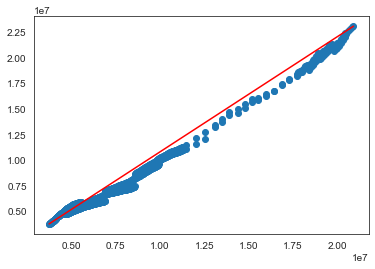

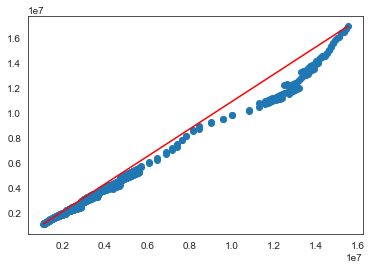

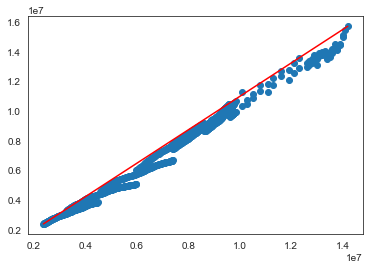

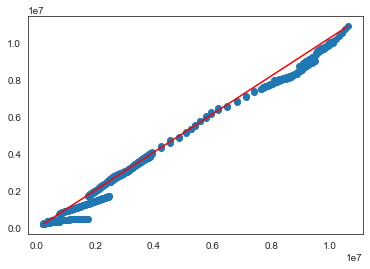

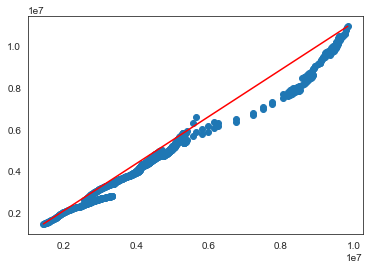

<Figure size 432x288 with 0 Axes>

In [56]:
for df in df_cv:
    plt.scatter(df.y,df.yhat)

    x_plt_range = [df.y.min(),df.y.max()]
    y_plt_range = [df.yhat.min(),df.yhat.max()]
    
    plt.plot(x_plt_range,y_plt_range,c="r")
    
    plt.figure()
    
    print(r2_score(df.y,df.yhat))
    
    
# plt.figure(figsize = [9,6])

# plt.grid()
# sns.set_style("white")

# plt.xlabel("WEEKS",fontsize = 10, weight = 'bold')
# plt.ylabel('ENTRY STATION PER WEEK',fontsize = 10, weight = 'bold')
# plt.title("ENTRY FOR STATION (34 ST-PENN STA) PER WEEK",fontsize = 15, weight = 'bold')
#     plot_cross_validation_metric(df, metric='mae')

In [59]:
df_cv[4]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-06-21 00:00:00,1.449965e+06,1.446570e+06,1.453360e+06,1441730,2018-06-20 04:00:00
1,2018-06-22 00:00:00,1.462660e+06,1.459286e+06,1.466040e+06,1459769,2018-06-20 04:00:00
2,2018-06-23 00:00:00,1.475374e+06,1.472039e+06,1.478746e+06,1479292,2018-06-20 04:00:00
3,2018-06-24 00:00:00,1.487789e+06,1.484657e+06,1.491143e+06,1497313,2018-06-20 04:00:00
4,2018-06-25 00:00:00,1.500198e+06,1.496711e+06,1.503502e+06,1514965,2018-06-20 04:00:00
...,...,...,...,...,...,...
901,2021-08-22 04:00:00,1.064410e+07,1.035145e+07,1.093180e+07,9770000,2021-04-05 04:00:00
902,2021-08-30 04:00:00,1.074527e+07,1.043475e+07,1.105303e+07,9790000,2021-04-05 04:00:00
903,2021-09-07 04:00:00,1.083715e+07,1.049319e+07,1.116878e+07,9800000,2021-04-05 04:00:00
904,2021-09-15 04:00:00,1.090487e+07,1.053839e+07,1.127738e+07,9820000,2021-04-05 04:00:00


In [67]:
def my_func(low,up,leng):
    list = []
    step = (up - low) / float(leng)
    for i in range(leng):
        list.append(low)
        low = low + step
    return list

In [73]:
t=my_func(1441730,9840000,10)

'[[1441730, 2281557.0, 3121384.0, 3961211.0, 4801038.0, 5640865.0, 6480692.0, 7320519.0, 8160346.0, 9000173.0]]'

Text(0.5, 1.0, 'ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS FOR TOP 4th CHANNEL(VALIDATION)')

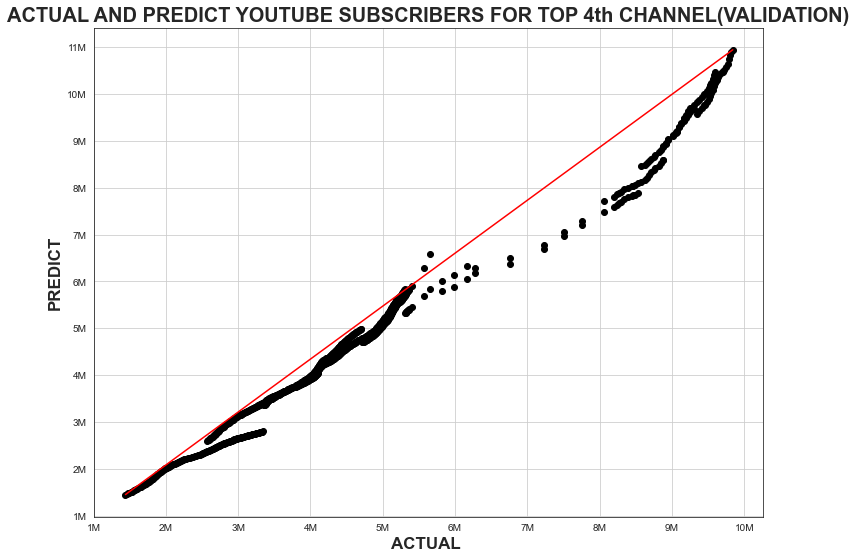

In [106]:
plt.figure(figsize = [12,9])
plt.scatter(df_cv[4].y,df_cv[4].yhat,c="black")

x_plt_range = [df_cv[4].y.min(),df_cv[4].y.max()]
y_plt_range = [df_cv[4].yhat.min(),df_cv[4].yhat.max()]
    
plt.plot(x_plt_range,y_plt_range,c="r")
    

plt.xticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 
7000000, 8000000, 9000000, 10000000],
["1M", "2M", "3M", "4M", "5M", "6M", 
"7M", "8M", "9M", "10M"])
plt.yticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 
7000000, 8000000, 9000000, 10000000,11000000],
["1M", "2M", "3M", "4M", "5M", "6M", 
"7M", "8M", "9M", "10M","11M"])



plt.grid()
sns.set_style("white")
plt.xlabel("ACTUAL ",fontsize = 17, weight = 'bold')
plt.ylabel('PREDICT',fontsize = 17, weight = 'bold')
plt.title("ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS FOR TOP 4th CHANNEL(VALIDATION)",fontsize = 20, weight = 'bold')

## Training Plots

0.9987670762148646
0.99928507964654
0.9997238393975183
0.9998454796385761
0.9990587666544882


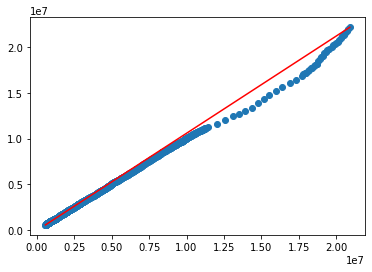

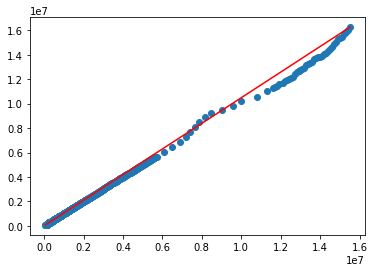

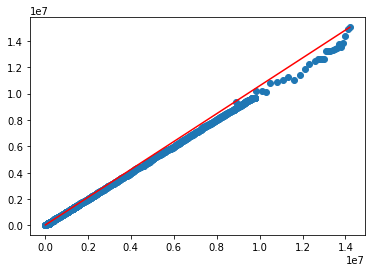

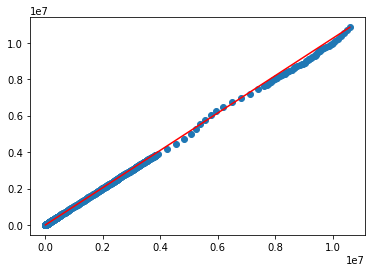

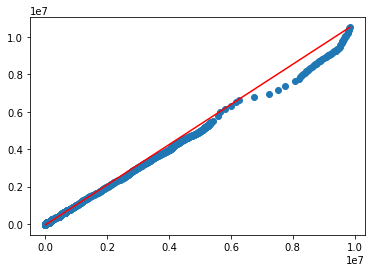

<Figure size 432x288 with 0 Axes>

In [42]:
for y_yhat in ys_yhats:
    print(r2_score(y_yhat["y"],y_yhat["yhat"]))
    plt.scatter(y_yhat["y"],y_yhat["yhat"])
    x_plt_range = [y_yhat["y"].min(),y_yhat["y"].max()]
    y_plt_range = [y_yhat["yhat"].min(),y_yhat["yhat"].max()]
    plt.plot(x_plt_range,y_plt_range,c="r")
    plt.figure()
    

Text(0.5, 1.0, 'ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS FOR TOP 4th CHANNEL(TRAIN)')

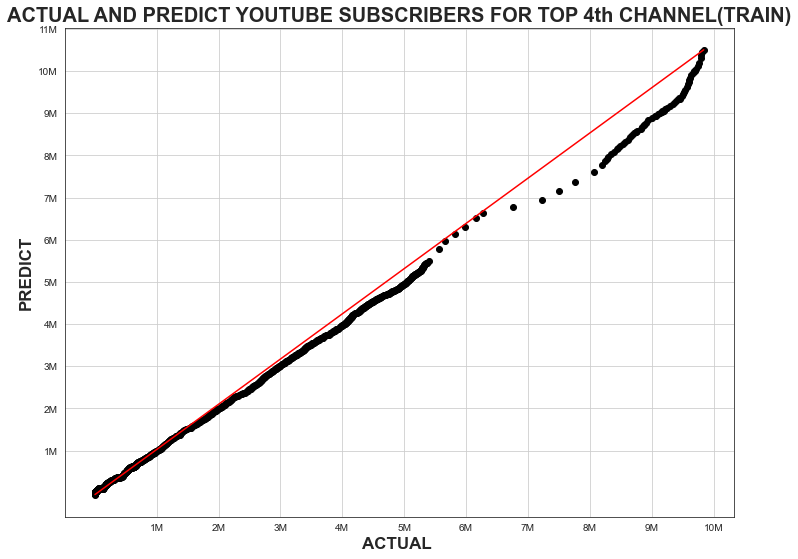

In [108]:
plt.figure(figsize = [12,9])
plt.scatter(y_yhat["y"],y_yhat["yhat"],c="black")
x_plt_range = [y_yhat["y"].min(),y_yhat["y"].max()]
y_plt_range = [y_yhat["yhat"].min(),y_yhat["yhat"].max()]
plt.plot(x_plt_range,y_plt_range,c="r")

plt.xticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 
7000000, 8000000, 9000000, 10000000],
["1M", "2M", "3M", "4M", "5M", "6M", 
"7M", "8M", "9M", "10M"])
plt.yticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 
7000000, 8000000, 9000000, 10000000,11000000],
["1M", "2M", "3M", "4M", "5M", "6M", 
"7M", "8M", "9M", "10M","11M"])

plt.grid()
sns.set_style("white")
plt.xlabel("ACTUAL ",fontsize = 17, weight = 'bold')
plt.ylabel('PREDICT',fontsize = 17, weight = 'bold')
plt.title("ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS FOR TOP 4th CHANNEL(TRAIN)",fontsize = 20, weight = 'bold')

In [ ]:
# tss = TimeSeriesSplit()
# for tarin,val in tss.split(X_y):
md = Prophet()
md.fit(X_y)

In [ ]:
# for train,val in kf:
#     print("train Range:",min(train),max(train),"val Range:",min(val),max(val))
X_y.ds

In [ ]:
df_cv = cross_validation(md,initial='730 days', period='100 days', horizon = '200 days')

In [ ]:
df_cv

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(df_cv.y,df_cv.yhat)
plt.plot([0.7e7,2.2e7],[0.7e7,2.2e7],c="r")

In [ ]:
r2_score(df_cv.y,df_cv.yhat)

In [ ]:
df_p = performance_metrics(df_cv)
df_p

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [ ]:
future = md.make_future_dataframe(periods=365)

In [ ]:
future

In [ ]:
forecast = md.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
 md.plot_components(forecast)

In [ ]:
y_yhat = top1_m.merge(forecast[["ds","yhat"]],left_on="Date",right_on="ds")
r2_score(y_yhat["TotalVideoViews"],y_yhat["yhat"])

In [ ]:
r2_score()

In [ ]:
df1[(df1["Weekly Subscribers Gained"] == 100000)]

# needs to check it 


In [ ]:
with open('req0.html') as page:
    html = page.read()
soup = BeautifulSoup(html, 'lxml')

In [ ]:
#print(soup.prettify())

In [ ]:
# up_string = soup.find_all(text=re.compile('Up'))
# up_string

In [ ]:
# rows = [row for row in soup.find_all("span",class_="YouTubeUserTopLight")]
# rows

In [ ]:
# soup.find_all("span",class_="YouTubeUserTopLight")[0].text

In [ ]:
# rows = [row for row in soup.find_all("span",style="font-weight: bold;")] 
# rows[0:6]

In [ ]:
list_columns=[]
for i in soup.find_all("span",class_="YouTubeUserTopLight"):
        list_columns.append(i.get_text())
print(list_columns)

In [ ]:
list_req0=[]
for i in soup.find_all("span",style="font-weight: bold;"):
        list_req0.append(i.get_text())
print(list_req0)